# Data exploration

In [54]:
import laspy
from scipy.spatial import cKDTree
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from sklearn.preprocessing import MinMaxScaler


In [55]:
def get_spatial_subset(
    full_cloud, xmin: int, xmax: int, ymin: int, ymax: int
) -> laspy.lasdata.LasData:
    """
    Create a subset of a LAS file based on a bounding box in coordinates of the cloud file

    parameters:
    full_cloud: a laspy cloud object you want to subset from

    xmin: the values of the bounding box object
    xmax
    ymin
    ymax

    returns: laspy.lasdata.LasData object
    """
    # create empty laspy collection to put the filtered points in that has the same format and file version as the original
    new_file = laspy.create(
        point_format=cloud.header.point_format, file_version=cloud.header.version
    )
    # create matrices of boolean values
    a = cloud.x > xmin
    b = cloud.x < xmax
    c = cloud.y > ymin
    d = cloud.y < ymax
    # subset the points and put them into the new laspy file
    new_file.points = full_cloud.points[a & b & c & d]
    return new_file


In [56]:
# load in the fully LAZ file
cloud = laspy.read(r"./data/AHN4_Noordwijk.laz")


In [57]:
# define the area of interest
xcenter = 89400
bbbox_size = 300
ycenter = 472868
xmin = xcenter - 0.5 * bbbox_size
xmax = xcenter + 0.5 * bbbox_size
ymin = ycenter - 0.5 * bbbox_size
ymax = ycenter + 0.5 * bbbox_size

# create the subset
subset = get_spatial_subset(cloud, xmin, xmax, ymin, ymax)



In [58]:
# create a tree for all points in the subset
dataset = np.vstack((subset.X, subset.Y, subset.Z)).transpose()
tree = cKDTree(dataset)


In [59]:
# setting up the extra dimensions to add back to the las file
dimension = laspy.point.format.ExtraBytesParams("normal_angle", "float64")
subset.add_extra_dim(dimension)
# check that it was added correctly


In [60]:
list(subset.point_format.dimension_names)


['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'nir',
 'Deviation',
 'Reflectance',
 'Amplitude',
 'normal_angle']

In [61]:
# get an array for all the points
all_points = subset.points.array


In [62]:
a = _fit_plane_pca(all_points[100],tree,k=8)

In [63]:
def _fit_plane_pca(point, tree, k=8) -> PCA:
    """
    internal function designed to fit a PCA model to the k nearest points to a point
    parameters:
    point: single point as structured ndarray of point data returned from laspy.points.array()
    tree: the KD tree for the points
    k: number of neighbors to consider

    returns:
    fitted pca model: sklean.decom
    """
    distances, neighbors_indices = tree.query((point[0], point[1], point[2]), k=8)

    neighbors_points = tree.data[neighbors_indices]
    # set up pca model
    pca = PCA(n_components=3)
    # fit the model to the points
    pca.fit(neighbors_points)
    return pca


In [64]:
def pca_3d_shape(point_array: np.array, tree: cKDTree, k: int = 8) -> np.array:
    """
    takes an array of points from laspy, a kd tree, and an integer number of neighbors to sample


    returns an array of:

    linearity, planarity, scattering, omnivariance, anisotropy, eigenentropy, eigsum, ch_cur

    """
    length_parray = len(point_array)
    normal_angle = np.zeros(length_parray)
    normal_vectors = np.zeros((length_parray, 3))
    # set up empty arrays
    linearity = np.zeros(length_parray)
    planarity = np.zeros(length_parray)
    scattering = np.zeros(length_parray)
    omnivariance = np.zeros(length_parray)
    anisotropy = np.zeros(length_parray)
    eigenentropy = np.zeros(length_parray)
    eigsum = np.zeros(length_parray)
    ch_cur = np.zeros(length_parray)

    for i, point in enumerate(point_array):

        # get a fitted pca model
        pca = _fit_plane_pca(point, tree, k=8)

        # get the Z value for the normal
        normal_vector = pca.components_.T[2]

        # find the angle with the z axis using the dot product
        angle = np.rad2deg(np.arccos(normal_vector.dot([0, 0, 1])))

        # we want all the normals pointing in the same direction

        if angle > 90:
            # if the vector is point the wrong way, flip it
            normal_vector = normal_vector * -1
            # find the angle of the new vector
            angle = np.rad2deg(np.arccos(normal_vector.dot([0, 0, 1])))

        # save the angle in an array
        normal_angle[i] = angle
        # save the vector in an array
        normal_vectors[i] = normal_vector

        # Find the eigenvalues of the matrix
        eival1, eival2, eival3 = pca.singular_values_

        # calculate the following values and assign them to the correct spot in the array
        linearity[i] = (eival1 - eival2) / eival1
        planarity[i] = (eival2 - eival3) / eival1
        scattering[i] = eival3 / eival1
        omnivariance[i] = (eival1 * eival2 * eival3) ** (1 / 3)
        anisotropy[i] = (eival1 - eival3) / eival1
        eigenentropy[i] = -1 * (
            eival1 * np.log(eival1) + eival2 * np.log(eival2) + eival3 * np.log(eival3)
        )
        eigsum[i] = eival1 + eival2 + eival3
        ch_cur[i] = eival3 / (eival1 + eival2 + eival3)

    pca_geo_array = np.vstack(
        [
            linearity,
            planarity,
            scattering,
            omnivariance,
            anisotropy,
            eigenentropy,
            eigsum,
            ch_cur,
        ]
    ).T

    return normal_angle, pca_geo_array



In [65]:
normal_angle, pca_results = pca_3d_shape(all_points, tree, k=8)

# assign the calculated angle to the new dimension created above
subset.normal_angle = normal_angle
# save the file
subset.write(".\data\subsetted.las")


## Checking that the angles with the vertical makes sense

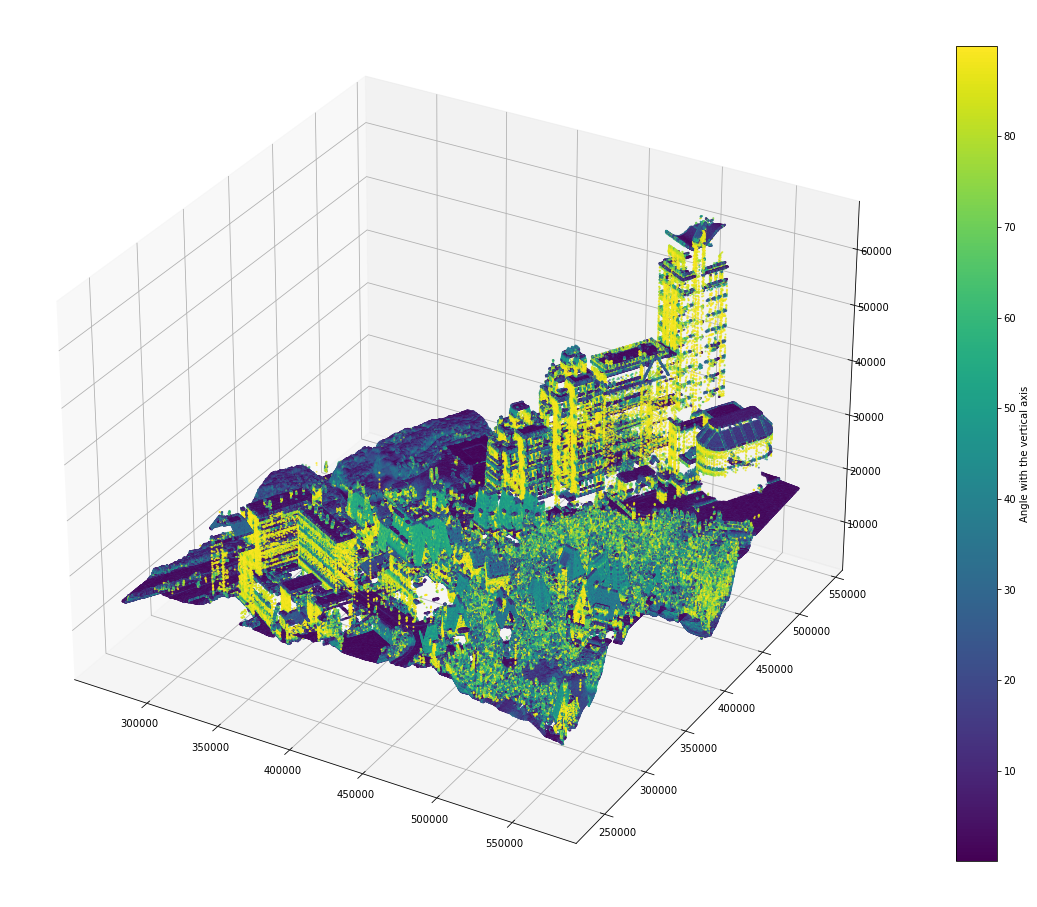

In [66]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
min_max_scaler = MinMaxScaler()
color = min_max_scaler.fit_transform(
    np.vstack([subset.red, subset.green, subset.blue]).T
)

p = ax.scatter(subset.X, subset.Y, subset.Z, s=1, c=subset.normal_angle)
ax.set_zlim3d(bottom=subset.Z.min())

plt.colorbar(p, shrink=0.75, label="Angle with the vertical axis")
plt.show()


In [67]:
## TODO delete this cell later when subset is finalized
# create a markdown table with max and min, to copy in to the cell below

for name in subset.point_format.dimension_names:
    # need to handle different methods for views that return arrays and views that return subviews
    try:
        mean_ = subset[name].mean()
    except:
        mean_ = "N/A"

    print(f"|{name}|{subset[name].max()}|{subset[name].min()}|{mean_}|  |")



|X|569999|270001|434633.07191944995|  |
|Y|537999|238001|383854.2939975526|  |
|Z|64048|2232|18978.041400106056|  |
|intensity|3402|48|956.6175204558147|  |
|return_number|5|1|N/A|  |
|number_of_returns|6|1|N/A|  |
|synthetic|0|0|N/A|  |
|key_point|0|0|N/A|  |
|withheld|0|0|N/A|  |
|overlap|0|0|N/A|  |
|scanner_channel|0|0|N/A|  |
|scan_direction_flag|1|0|N/A|  |
|edge_of_flight_line|1|0|N/A|  |
|classification|0|0|0.0|  |
|user_data|7|6|6.515641933386316|  |
|scan_angle|-2333|-5167|-3694.497174559769|  |
|point_source_id|103|102|102.53380304345988|  |
|gps_time|270040553.2988468|270039062.1103645|270039858.0552928|  |
|red|65280|8704|35152.18255124802|  |
|green|65280|9728|34611.112895376464|  |
|blue|65280|6144|32078.841084209296|  |
|nir|0|0|0.0|  |
|Deviation|65535.0|0.0|953.2627702582656|  |
|Reflectance|19.290000915527344|-15.029999732971191|-5.306954141524299|  |
|Amplitude|34.02000045776367|0.47999998927116394|9.5661752048656|  |
|normal_angle|89.99994870821386|0.00024249726727

a) Investigate the data set: describe each of its columns and assess the spread in values in each column. What is the meaning of each attribute?

| Column name         | max                | min                  | average            | description |
| ------------------- | ------------------ | -------------------- | ------------------ | ----------- |
| X                   | 469999             | 370001               | 419845.4310215496  |             |
| Y                   | 437999             | 338001               | 387008.1474969034  |             |
| Z                   | 38855              | 12340                | 21268.85938497757  |             |
| intensity           | 3402               | 64                   | 972.2795605443956  |             |
| return_number       | 5                  | 1                    | N/A                |             |
| number_of_returns   | 5                  | 1                    | N/A                |             |
| synthetic           | 0                  | 0                    | N/A                |             |
| key_point           | 0                  | 0                    | N/A                |             |
| withheld            | 0                  | 0                    | N/A                |             |
| overlap             | 0                  | 0                    | N/A                |             |
| scanner_channel     | 0                  | 0                    | N/A                |             |
| scan_direction_flag | 1                  | 0                    | N/A                |             |
| edge_of_flight_line | 1                  | 0                    | N/A                |             |
| classification      | 0                  | 0                    | 0.0                |             |
| user_data           | 7                  | 6                    | 6.450293893628971  |             |
| scan_angle          | -3167              | -4667                | -3831.702651966856 |             |
| point_source_id     | 103                | 102                  | 102.53481523938483 |             |
| gps_time            | 270040551.7498966  | 270039063.185381     | 270039859.1351014  |             |
| red                 | 65280              | 13568                | 37609.126151147495 |             |
| green               | 65280              | 14848                | 36093.92951169035  |             |
| blue                | 65280              | 12288                | 33891.48290108402  |             |
| nir                 | 0                  | 0                    | 0.0                |             |
| Deviation           | 65535.0            | 0.0                  | 667.5175162910932  |             |
| Reflectance         | 19.290000915527344 | -14.789999961853027  | -5.168461232916284 |             |
| Amplitude           | 34.02000045776367  | 0.6399999856948853   | 9.722795606371532  |             |
| normal_angle        | 89.99985593635134  | 0.001076368705341224 | 42.61863884341944  |             |

## Spread in RBG values

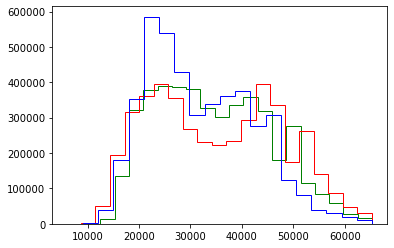

In [68]:
plt.hist(subset.green, bins=20, color="green", histtype="step")
plt.hist(subset.red, bins=20, color="red", histtype="step")
plt.hist(subset.blue, bins=20, color="blue", histtype="step")
plt.show()


b) What are ways to create a subset? Select a suitable subset of the data and visualize it in 3D. Start small, and if computer and software permits, try a bit larger subset


c) Identify at least four different object classes. Choose your classes such that together these cover a large majority of your points.

1. building
2. grass
3. pavement
4. tree
5. road

d) Analyse which spatial scales and spectral properties are useful to distinguish your classes.

The following properties are typical of each of the classes

1. building
   1. taller than the surroundings 
2. grass
   1. high NDVI
   2. 
3. pavement
   1. 
4. tree
   1. taller that it is wide or long
5. beach

e) Extract training data for each of your object classes. Divide your training data in two parts, one for training, and one for validation. What could be the influence of  imbalances in your training data? How could your division in training and validation data affect your results?


f) Find a suitable implementation of the Random Forest algorithm. What are its parameters? What would be good settings for these parameters, given your classification task? Apply Random Forest on your data using only your observed features, to make sure your setup is correct.


# Questions
## Describe the properties of the data (sub)set that you will classify: 
### How many points? 



In [69]:
print(f'The subset is {len(subset.points)} points long')

The subset is 4401438 points long


### What area does it cover? 

In [70]:
print(
    f"Bounding box is between {xmin} and {xmax} in the x direction and {ymin} and {ymax} in the y direction (referenced to the coordinates in the LAZ file)"
)

Bounding box is between 89250.0 and 89550.0 in the x direction and 472718.0 and 473018.0 in the y direction (referenced to the coordinates in the LAZ file)



### What observed features will you use? 
### Visualize your final subset, including the useful observed features. 

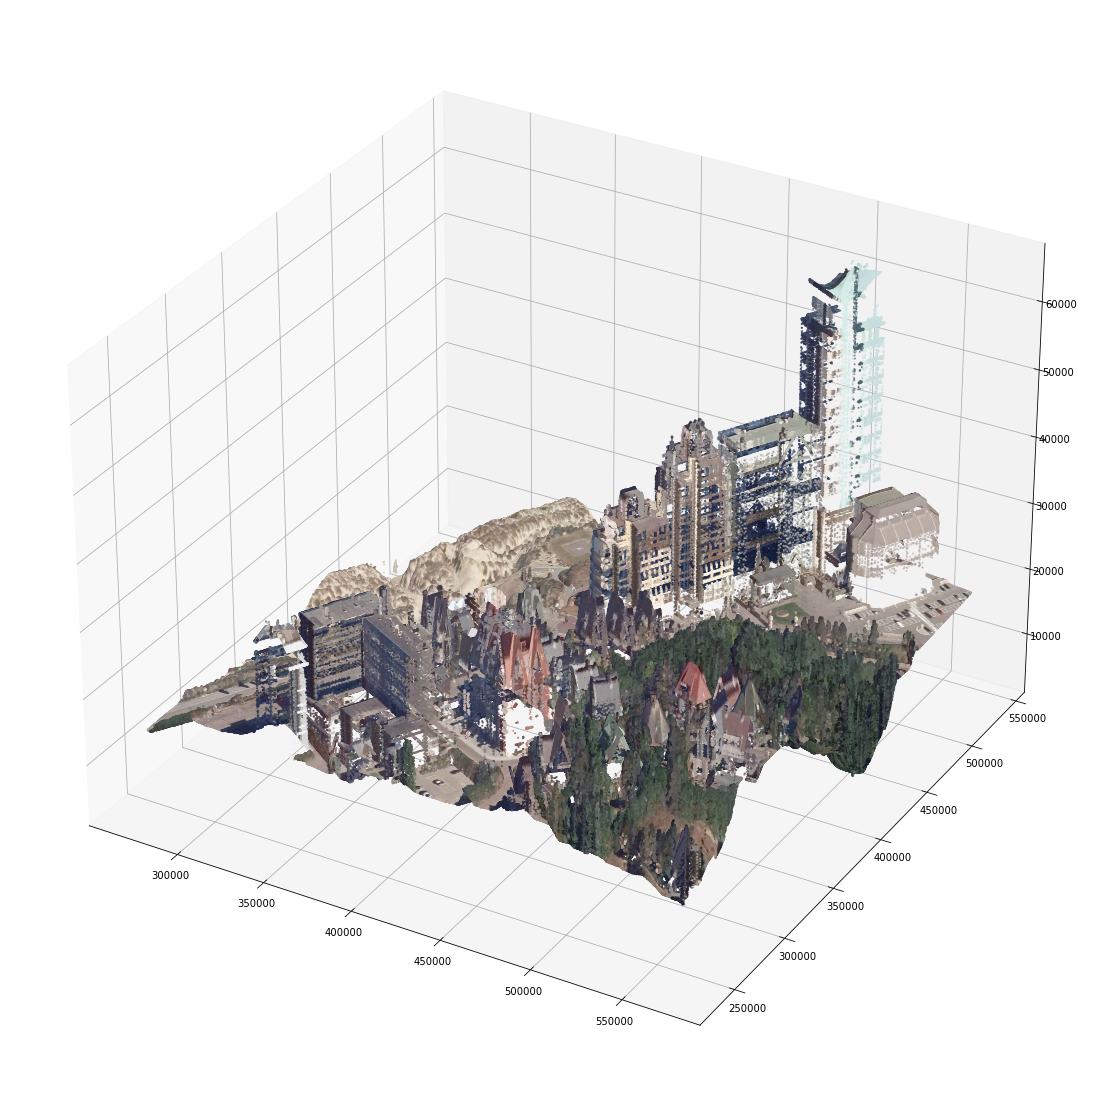

In [71]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
# colors need to range from 0-1, use minmax scaler to scale them down
min_max_scaler = MinMaxScaler()

color = min_max_scaler.fit_transform(
    np.vstack([subset.red, subset.green, subset.blue]).T
)

ax.scatter(subset.X, subset.Y, subset.Z, s=1, c=color)
ax.set_zlim3d(bottom=subset.Z.min())

plt.show()


### Describe your at least four different object classes; 

For each point determine neighborhoods of k1, k2, ... points (using e.g. an efficient data structure), and use these k1, k2, ... points to estimate several feature values.

2. Describe $\gt$ 20 different geometric attributes, obtained using at least 2 different neighborhood sizes, to characterize your points. What are the dimensions of the data covariance matrix you use to compute the geometric features? Give one example on how you determine the PCA eigenvalues of one k-neighborhood. Indicate for each feature how it could help to distinguish your classes, given also the neighborhood sizes you consider.


3. Compute all geometric features for all points in your subset using Python. Visualize selected results, e.g. by combining features in a false color visualization and/or using histograms. Which features are best at discriminating your classes? Why?



In [ ]:
def visualize_parameter():
    """
    Create a false color vis and a histogram with labels for each of the attributes
    """
    
    pass


4. Describe and visualize your training data. Is your training data balanced? Make sure that a zone of your point cloud data is really ’unseen’, that is that no training data is taken from that zone, so you can inspect if Random Forest also works there.
   

5. Feed your training data to Random Forest using at least 10 of your best geometric and observed features. What settings did you use?
   

6. Classify your point cloud data and visualize and discuss your result. What went well? Give also examples where the classifier mixed up classes. What are possible explanations for these confusions? How are the classification results on the unseen zone?